### Import packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import dill
import yaml
import numpy as np
import pandas as pd
import ast
import collections

import seaborn as sns
sns.set(style='ticks')

### Import submodular-optimization packages

In [2]:
sys.path.insert(0, "/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/")

### Visualizations directory

In [3]:
VIZ_DIR = os.path.abspath("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/viz/")

### Legends and style dictionary

In [4]:
legends = {
    "distorted_greedy":"DistortedGreedy",
    "cost_scaled_lazy_exact_greedy":"CSLG",
    "unconstrained_linear":"OnlineCSG",
    "unconstrained_distorted_greedy":"UnconstrainedDistortedGreedy",
    "stochastic_distorted_greedy_0.01":"StochasticDistortedGreedy",
    "baseline_topk": "Top-k-Experts",
    "greedy":"Greedy"
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'distorted_greedy':':',
               'cost_scaled_lazy_exact_greedy':'-',
               'unconstrained_linear':'-',
          'unconstrained_distorted_greedy':'-',
               'stochastic_distorted_greedy_0.01':'-.',
              'baseline_topk':'--',
              "greedy":"--"
              }

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'distorted_greedy':'s',
                'cost_scaled_lazy_exact_greedy':'x',
                'unconstrained_linear':'*',
          'unconstrained_distorted_greedy':'+',
                'stochastic_distorted_greedy_0.01':'o',
                'baseline_topk':'d',
                "greedy":"h"
               }

marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'distorted_greedy':25,
               'cost_scaled_lazy_exact_greedy':30,
               'unconstrained_linear':25,
          'unconstrained_distorted_greedy':25,
               'stochastic_distorted_greedy_0.01':25,
               'baseline_topk':22,
               "greedy":30
              }

marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'distorted_greedy':6,
               'cost_scaled_lazy_exact_greedy':10,
               'unconstrained_linear':10,
          'unconstrained_distorted_greedy':6,
               'stochastic_distorted_greedy_0.01':6,
                    'baseline_topk':6,
                    "greedy":6
                    }

marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'distorted_greedy':5,
              'cost_scaled_lazy_exact_greedy':5,
              'unconstrained_linear':5,
          'unconstrained_distorted_greedy':5,
              'stochastic_distorted_greedy_0.01':5,
              'baseline_topk':5,
              "greedy":5
             }

line_width = collections.OrderedDict(sorted(line_width.items()))

name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

### Plotting utilities

In [5]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

In [6]:
def set_size(fig, width=13, height=12):
    fig.set_size_inches(width, height)
    plt.tight_layout()

In [7]:
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=600, format='pdf', bbox_inches='tight')

### Preprocessing

In [8]:
df1 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_00_freelancer_pop01_rare01_final.csv",
                header=0,
                index_col=False)

df1.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

df2 = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_00_freelancer_pop01_rare01_greedy.csv",
                header=0,
                index_col=False)

df2.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

frames = []
frames.append(df1)
frames.append(df2)

df_final = pd.concat(frames)
df_final.to_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_00_freelancer_pop01_rare01.csv", index=False) 

#### Details
Original marginal gain: $$g(e|S) = f(e|S) - w(e)$$
Scaled marginal gain: $$\tilde{g}(e|S) = f(e|S) - 2w(e)$$
Distorted marginal gain: $$\tilde{g}(e|S) = (1-\frac{\gamma}{n})^{n-(i+1)}f(e|S) - w(e)$$ 

#### Algorithms:
1. Cost Scaled Greedy: The algorithm performs iterations i = 0,...,n-1. In each iteration the algorithm selects the element that maximizes the scaled marginal gain. It adds the element to the solution if the original marginal gain of the element is >= 0. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time is O($n^2$).


2. Cost Scaled Exact Lazy Greedy: The algorithm first initializes a max heap with all the elements. The key of each element is its scaled marginal gain and the value is the element id. If the scaled marginal gain of an element is < 0 the algorithm discards the element and never inserts it in the heap. Then, for 0,...,n-1 iterations the algorithm does the following: (i) pops the top element from the heap and computes its new scaled marginal gain, (ii) It checks the old scaled marginal gain of the next element in the heap, (iii) if the popped element's new scaled marginal gain is >= the next elements's old gain we return the popped element, otherwise if its new scaled marginal gain is >= 0 we reinsert the element to the heap and repeat step iii, otherwise we discard it and repeat step iii, (iv) if the returned element's original marginal gain is >= 0 we add it to the solution. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time is O($n^2$).


3. Unconstrained Linear: The algorithm performs i = 0,...,n-1 iterations (one for each arriving element). For each element it adds it to the solution if its scaled marginal gain is > 0. The algorithm returns a solution S: f(S) - w(S) >= (1/2)f(OPT) - w(OPT). The running time is O($n$).


4. Distorted Greedy: The algorithm performs i = 0,...,n-1 iterations. In each iteration the algorithm selects the element that maximizes the distorted marginal gain. It adds the element to the solution if the distorted marginal gain of the element is > 0. The algorithm returns a solution S: f(S) - w(S) >= (1-1/e)f(OPT) - w(OPT). The running time is O($n^2$). The algorithmic implementation is based on Algorithm 1 found [here](https://arxiv.org/pdf/1904.09354.pdf) for k=n.


5. Stochastic Distorted Greedy: The algorithm performs i = 0,...,n-1 iterations. In each iteration the algorithm chooses a sample of s=log(1/ε) elements uniformly and independently and from this sample it selects the element that maximizes the distorted marginal gain. It adds the element to the solution if the distorted marginal gain of the element is > 0. We set $ε=0.01$. The algorithm returns a solution S: E[f(S) - w(S)] >= (1-1/e-ε)f(OPT) - w(OPT). The running time is O($n\log{1/ε}$). The algorithmic implementation is based on Algorithm 2 found [here](https://arxiv.org/pdf/1904.09354.pdf) for k=n.


6. Unconstrained Distorted Greedy: The algorithm performs i = 0,...,n-1 iterations. In each iteration the algorithm chooses a random single element uniformly. It adds the element to the solution if the distorted marginal gain of the element is > 0. The algorithm returns a solution S: E[f(S) - w(S)] >= (1-1/e)f(OPT) - w(OPT). The running time is O($n$).

#### Performance comparison

In [9]:
def plot_performance_comparison(df):
    
    palette = sns.color_palette(['#b30000','#dd8452', '#4c72b0','#ccb974',
                                 '#55a868', '#64b5cd', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],7)
    
    ax = sns.lineplot(x='user_sample_ratio', y='val', data=df, 
                      style="Algorithm",hue='Algorithm', ci='sd', 
                      mfc='none',palette=palette, dashes=False)
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
    plt.yticks(np.arange(0, 45000, 5000))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Expert sample fraction', fontsize=fontsize)
    plt.ylabel(name_objective, fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})
    ax = plt.gca()
    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    return fig, ax

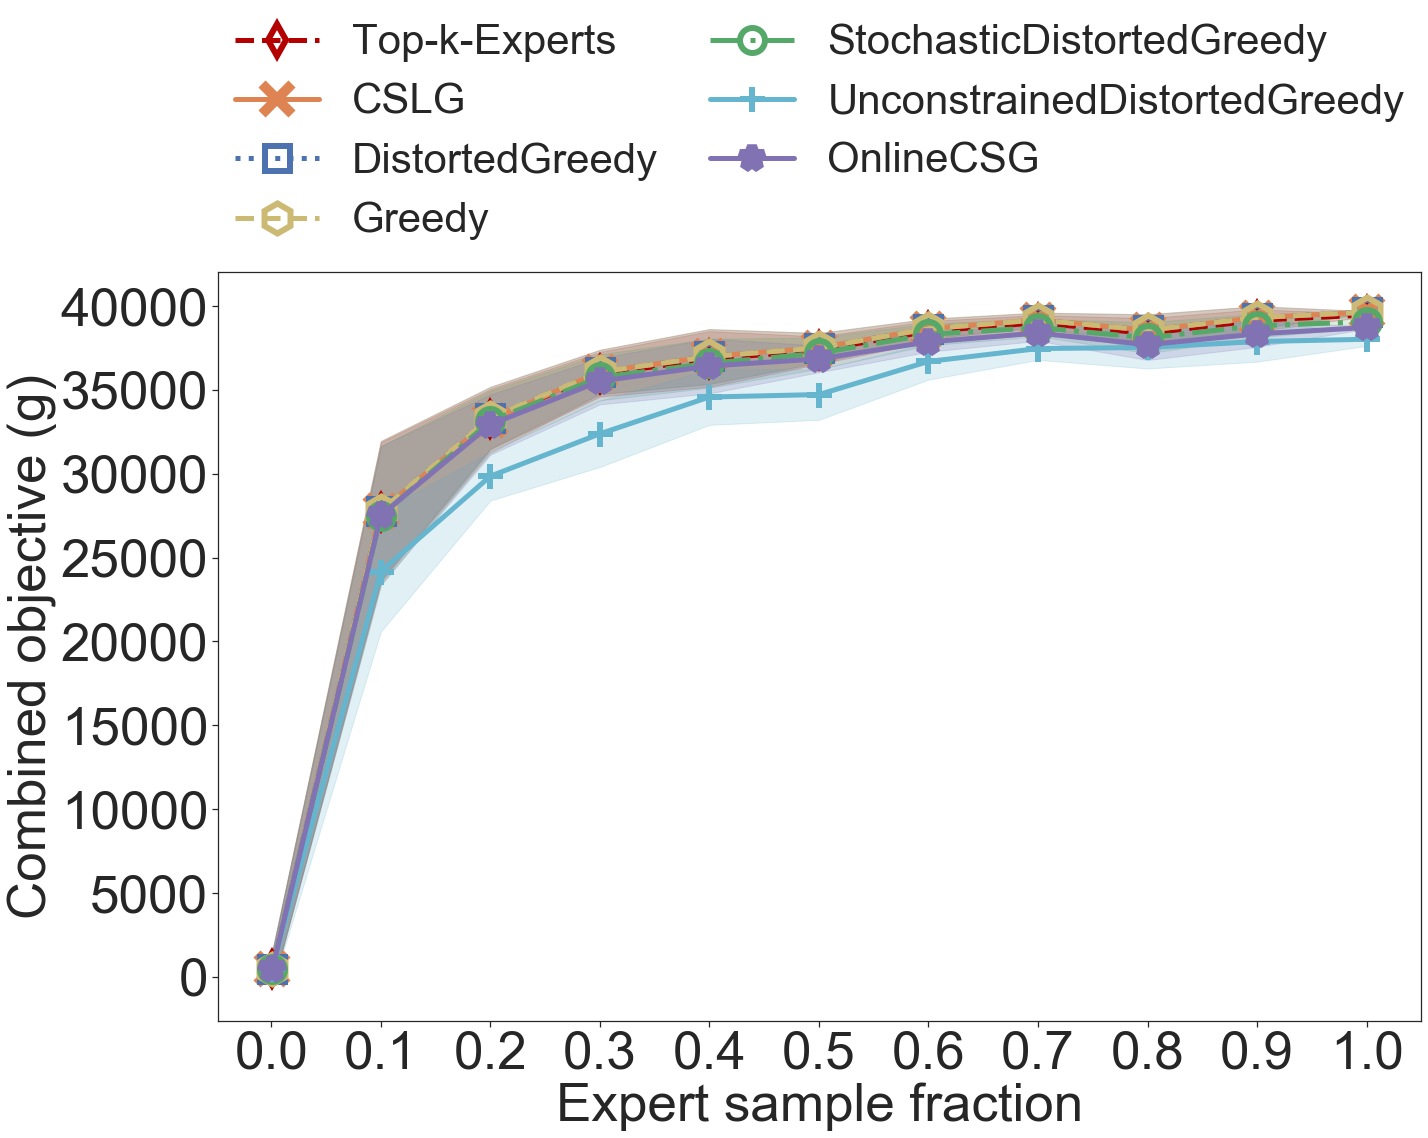

In [10]:
df = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_00_freelancer_pop01_rare01.csv",
                header=0,
                index_col=False)

df.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

df = df[(df.Algorithm == 'distorted_greedy')
        # |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_greedy')
        |(df.Algorithm == 'unconstrained_linear')
        |(df.Algorithm == 'unconstrained_distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy_0.01')
        |(df.Algorithm == 'baseline_topk')
        |(df.Algorithm == 'greedy')
    ]
df0 = df[(df['sample_epsilon'].isnull()) | (df['sample_epsilon'] == 0.01)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'score_unconstrained_freelancer_pop01_rare01.pdf')

#### Runtime comparison for different dataset sizes

In [11]:
legends = {
    "distorted_greedy":"DistortedGreedy",
    "cost_scaled_greedy":"CSG",
    "cost_scaled_lazy_exact_greedy":"CSLG",
    "unconstrained_linear":"OnlineCSG",
    "unconstrained_distorted_greedy":"UnconstrainedDistortedGreedy",
    "stochastic_distorted_greedy_0.01":"StochasticDistortedGreedy",
    "baseline_topk": "Top-k-Experts",
    "greedy":"Greedy"
}

legends = collections.OrderedDict(sorted(legends.items()))

line_styles = {'distorted_greedy':':',
               'cost_scaled_greedy':'-',
               'cost_scaled_lazy_exact_greedy':'-',
               'unconstrained_linear':'-',
          'unconstrained_distorted_greedy':'-',
               'stochastic_distorted_greedy_0.01':'-.',
              'baseline_topk':'--',
              "greedy":"--"
              }

line_styles = collections.OrderedDict(sorted(line_styles.items()))

marker_style = {'distorted_greedy':'s',
                'cost_scaled_greedy':'x',
                'cost_scaled_lazy_exact_greedy':'x',
                'unconstrained_linear':'*',
          'unconstrained_distorted_greedy':'+',
                'stochastic_distorted_greedy_0.01':'o',
                'baseline_topk':'d',
                "greedy":"h"
               }

marker_style = collections.OrderedDict(sorted(marker_style.items()))

marker_size = {'distorted_greedy':25,
               'cost_scaled_greedy':30,
               'cost_scaled_lazy_exact_greedy':30,
               'unconstrained_linear':25,
          'unconstrained_distorted_greedy':25,
               'stochastic_distorted_greedy_0.01':25,
               'baseline_topk':22,
               "greedy":30
              }

marker_size = collections.OrderedDict(sorted(marker_size.items()))

marker_edge_width = {'distorted_greedy':6,
                     'cost_scaled_greedy':10,
               'cost_scaled_lazy_exact_greedy':10,
               'unconstrained_linear':6,
          'unconstrained_distorted_greedy':6,
               'stochastic_distorted_greedy_0.01':6,
                    'baseline_topk':6,
                    "greedy":6
                    }

marker_edge_width = collections.OrderedDict(sorted(marker_edge_width.items()))

line_width = {'distorted_greedy':5,
              'cost_scaled_greedy':5,
              'cost_scaled_lazy_exact_greedy':5,
              'unconstrained_linear':5,
          'unconstrained_distorted_greedy':5,
              'stochastic_distorted_greedy_0.01':5,
              'baseline_topk':5,
             "greedy":5}

line_width = collections.OrderedDict(sorted(line_width.items()))


name_objective = "Combined objective (g)"
fontsize = 53
legendsize = 42
labelsize = 53
x_size = 20
y_size = 16

def plot_performance_comparison(df):
    
    palette = sns.color_palette(['#b30000','#937860','#dd8452', '#4c72b0','#ccb974'
                                 ,'#55a868', '#64b5cd', 
                                 '#8172b3', '#937860', '#da8bc3', '#8c8c8c', 
                                 '#ccb974', '#64b5cd'],8)
    
    ax = sns.lineplot(x='user_sample_ratio', y='runtime', data=df, 
                      style="Algorithm",hue='Algorithm', ci='sd', 
                      mfc='none',palette=palette, dashes=False)
    i = 0
    for key, val in line_styles.items():
        ax.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax.lines[i].set_linewidth(line_width[key])
        ax.lines[i].set_marker(marker_style[key])
        ax.lines[i].set_markersize(marker_size[key])
        ax.lines[i].set_markeredgewidth(marker_edge_width[key])
        ax.lines[i].set_markeredgecolor(None)
        i += 1
    
#     plt.yticks(np.arange(0, 45000, 5000))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Expert sample fraction', fontsize=fontsize)
    plt.ylabel('Time (sec)', fontsize=fontsize)
    # plt.title('Performance comparison')
    fig = plt.gcf()
    figlegend = plt.legend([val for key,val in legends.items()],loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=2, mode="expand", borderaxespad=0., frameon=False,prop={'size': legendsize})
    ax = plt.gca()
    plt.gca().tick_params(axis='y', labelsize=labelsize)
    plt.gca().tick_params(axis='x', labelsize=labelsize)
    
    a = plt.axes([.17, .43, .35, .3])
    ax2 = sns.lineplot(x='user_sample_ratio', y='runtime', data=df, 
                      hue='Algorithm', legend=False,
                      mfc='none',palette=palette,label=False)
    
    i = 0
    for key, val in line_styles.items():
        ax2.lines[i].set_linestyle(val)
        # ax.lines[i].set_color(colors[key])
        ax2.lines[i].set_linewidth(2)
        ax2.lines[i].set_marker(marker_style[key])
        ax2.lines[i].set_markersize(12)
        ax2.lines[i].set_markeredgewidth(3)
        ax2.lines[i].set_markeredgecolor(None)
        i += 1
    
    ax2.set(ylim=(0, 2))
    ax2.set(xlim=(0, 1))
    ax2.set_ylabel('')    
    ax2.set_xlabel('')
    
    # plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    # plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.gca().tick_params(axis='x', labelsize=22)
    plt.gca().tick_params(axis='y', labelsize=22)
    
    return fig, ax


/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until


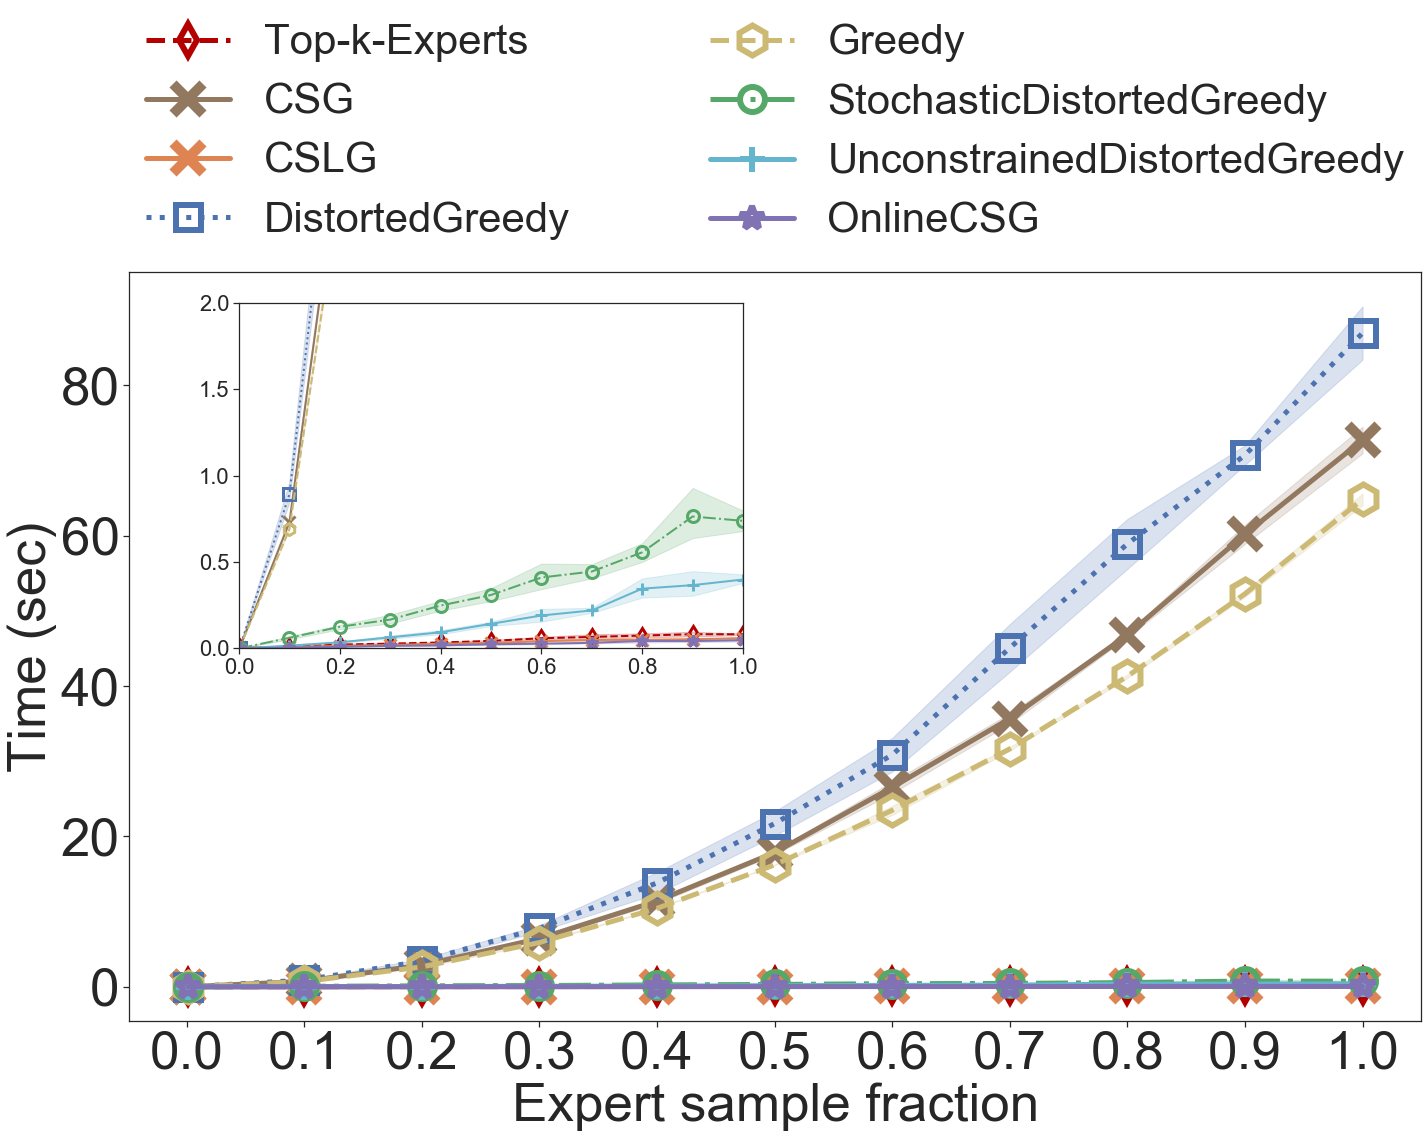

In [12]:
df = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_00_freelancer_pop01_rare01.csv",
                header=0,
                index_col=False)

df.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_greedy')
        |(df.Algorithm == 'unconstrained_linear')
        |(df.Algorithm == 'unconstrained_distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy_0.01')
        |(df.Algorithm == 'baseline_topk')
        |(df.Algorithm == 'greedy'
         )
    ]
df0 = df[(df['sample_epsilon'].isnull()) | (df['sample_epsilon'] == 0.01)]
df0.sort_values(by ='Algorithm',inplace=True)
set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, x_size, y_size)
save_fig(fig,'time_unconstrained_freelancer_pop01_rare01.pdf')